In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/sasuke/PycharmProjects/MT/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# -2 to 2
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [4]:
image_base_dir = './data/dog_cat'

datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(image_base_dir, x), transform=data_transforms[x]) for
            x in
            ['train', 'val']}

In [5]:
dataset_size = {x: len(y) for x, y in datasets.items()}

In [6]:
# show the image
# val set
examples = iter(datasets['train'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) 0


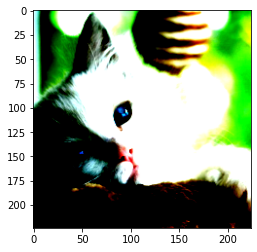

In [7]:
input_features, input_labels = next(examples)
print(input_features.shape, input_labels)
image = np.transpose(input_features, (1, 2, 0))
plt.imshow(image)
plt.show()

In [8]:
# data loader
data_loaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                               shuffle=True, num_workers=0)
                for x in ['train', 'val']}

In [ ]:
# train_model
def train_model(model, criterion, opt, lr_scheduler, num_epochs=25):
    since = time.time()

    # load the current best model params
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = .0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        opt.zero_grad()
                        loss.backward()
                        opt.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
class_names = ['cat', 'dog']
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optim = optim.SGD(model.parameters(), lr=.01)

step_lr_scheduler = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

model = train_model(model, criterion, optim,
                    step_lr_scheduler, num_epochs=20)